In [1]:
#pip install pandas numpy scikit-learn matplotlib yfinance tensorflow[and-cuda] scikeras keras_tuner

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import keras_tuner as kt
import seaborn as sns
from keras_tuner import HyperModel, Hyperband

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow import keras

from graphing import graph_normal, show_results, graph_line
from results import get_num_correct_direction_difference
from get_data import get_apple_stock_split , get_recent_apple_stock_split

2025-04-19 13:54:26.893854: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-19 13:54:28.841352: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745067268.316790  182532 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745067268.489747  182532 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745067270.069351  182532 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
scaler_X = MinMaxScaler(feature_range=(-1, 1))
scaler_Y = MinMaxScaler(feature_range=(-1, 1))

DAYS_LAG = 13

X_train, X_test, y_train, y_test = get_apple_stock_split(DAYS_LAG)
print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")


X_train = scaler_X.fit_transform(X_train)
y_train = scaler_Y.fit_transform(y_train)

X_test = scaler_X.transform(X_test)
y_test = scaler_Y.transform(y_test)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Training samples: 1772, Testing samples: 444


In [4]:
def create_ann(hp):
    model = keras.Sequential()
    model.add(keras.Input(shape=(X_train.shape[1],)))  # Input layer

    # Hyperparameter for number of hidden layers
    num_layers = 8

    for i in range(num_layers):
        model.add(keras.layers.Dense(
            units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32),
            activation=hp.Choice(f'activation_{i}', values=['relu', 'tanh', 'sigmoid'])
        ))

    # Output layer
    model.add(keras.layers.Dense(1, activation='linear'))

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', [0.001, 0.01, 0.0001,1.0])),
        loss='mse',
        metrics=['mae']
    )

    return model

In [5]:
tuner = kt.RandomSearch(
    create_ann,
    objective='val_mae',
    max_trials=10,
    executions_per_trial=2,
    directory='tuning_dir',
    project_name='time_series_ann',
    overwrite=True  # <-- This forces a fresh search
)
tuner.search(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

Trial 10 Complete [00h 00m 42s]
val_mae: 0.08702229708433151

Best val_mae So Far: 0.08680903166532516
Total elapsed time: 00h 07m 04s


In [6]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)

{'units_0': 160, 'activation_0': 'relu', 'units_1': 64, 'activation_1': 'sigmoid', 'units_2': 192, 'activation_2': 'relu', 'units_3': 96, 'activation_3': 'sigmoid', 'units_4': 128, 'activation_4': 'sigmoid', 'units_5': 96, 'activation_5': 'tanh', 'units_6': 192, 'activation_6': 'relu', 'units_7': 160, 'activation_7': 'tanh', 'learning_rate': 0.001}


In [7]:
# Get the best model found by the tuner
final_model = tuner.get_best_models(num_models=1)[0]

# Predict on test data
predictions = scaler_Y.inverse_transform(final_model.predict(X_test).reshape(-1,1))
actual = scaler_Y.inverse_transform(y_test)

mae = mean_absolute_error(actual, predictions)
mse = mean_squared_error(actual, predictions)
rmse = np.sqrt(mse)

print(f"Final Model RMSE: {rmse}")
print(f"Final Model MAE: {mae}")

/mnt/c/Users/kenan/dev/university_final_year_project/venv_linux/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
Final Model RMSE: 1.7168047052836926
Final Model MAE: 0.9573634838266731


[*********************100%***********************]  1 of 1 completed

1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2025-04-19 14:02:10.821889: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_40', 768 bytes spill stores, 768 bytes spill loads

2025-04-19 14:02:10.923404: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_62', 768 bytes spill stores, 768 bytes spill loads



7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 638ms/step
RMSE: 3.077524039378354
MAE: 2.2994251251220703


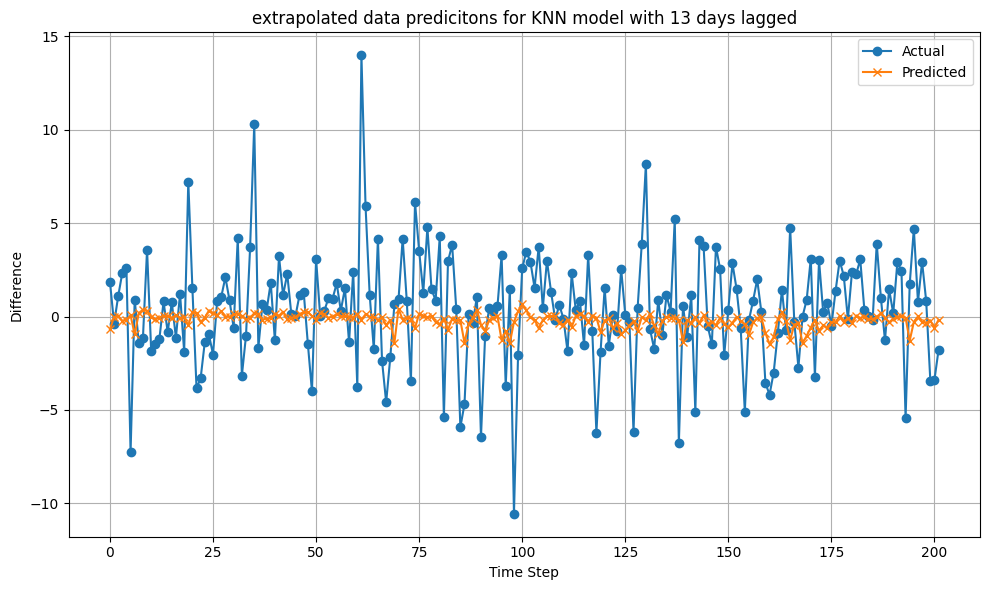

Price   Ticker
Target            95
dtype: int64 correct directions out of a total: 202


/mnt/c/Users/kenan/dev/university_final_year_project/venv_linux/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Price   Ticker
Target            95
dtype: int64

In [8]:
# trying to predict more recent ones
X, y = get_recent_apple_stock_split(DAYS_LAG)

X_scaled = scaler_X.transform(X)

predictions = scaler_Y.inverse_transform(final_model.predict(X_scaled).reshape(-1,1))

mae = mean_absolute_error(y, predictions)
mse = mean_squared_error(y, predictions)
rmse = np.sqrt(mse)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

graph_line(predictions, y, f"extrapolated data predicitons for KNN model with {DAYS_LAG} days lagged")
get_num_correct_direction_difference(predictions,y)